##LGBIO1114 - Organes artificiels et réhabilitation

__Auteur :__ Antoine De Comite

__Contenu :__ A l'issue de cette séance vous devriez être capables de : 

*   Décrire le fonctionnement d'un implant cochléaire
*   Comprendre et savoir appliquer les stratégies SPEAK et ICE dans le cadre d'un implant cochléaire



In [ ]:
#@title Librairies utiles 
# Please execute this cell to launch the tutorial 

import numpy as np 
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
#@title Création des signaux
# Please execute this cell to launch the tutorial

def createSignal():
  #This function creates the signal for the second tutorial of LGBIO1114

  np.random.seed(42)
  amplitudes = np.random.uniform(low=0.5,high=4,size=(25,1))
  frequencies = np.random.uniform(low=20,high=5000,size=(25,1))
  phases = np.random.uniform(low=0,high=2*np.pi,size=(25,1))
  time_vector = np.linspace(0,1,10000)
  signal_vector = np.zeros_like(time_vector)
  for ii in range(len(amplitudes)):
    signal_vector = signal_vector + amplitudes[ii]*np.sin(2*np.pi*frequencies[ii]*time_vector*time_vector+phases[ii])
  
  S = np.vstack((time_vector,signal_vector))

  return S


## Partie 0 - Introduction

En appelant la fonction *CreateSignal* (vous pouvez utiliser *S = CreateSignql()*)vous aurez accès à un signal tel que le patient devrait l'entendre et qu'il faudra essayer de récupérer au mieux dans votre solution.


On vous demande, d'implémenter les deux stratégies discutées dans l'introduction, à savoir les stratégies SPEAK et ACE, appliquées au signal fourni par la fonction *CreateSignal*.

Comparez les performances et capacités de ces deux techniques, qu'en concluez-vous? 

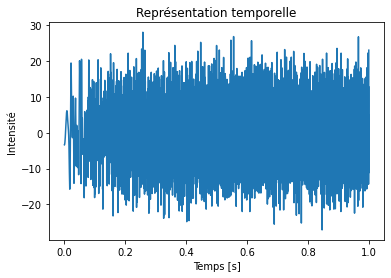

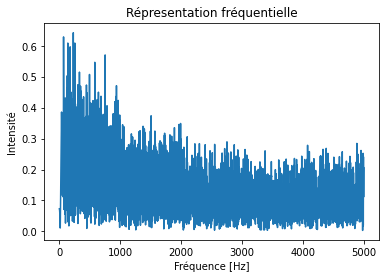

In [ ]:
# Nous allons recupérer les fonctions définines dans les séances précédentes pour nous aider 
def RepresTemporelle(t_vector,input_signal):
  # Le but de cette fonciton est de représenter un signal dans le domaine temporel
  # Inputs : t_vector le vecteur temporel
  #          input_signal le signal 
  #
  # Outputs : Aucun
  plt.plot(t_vector,input_signal)
  plt.title('Représentation temporelle')
  plt.xlabel('Temps [s]')
  plt.ylabel('Intensité')
  plt.show()
def computeTF(t_vector,input_signal):
  # Le but de cette fonction est de calculer la transformée de Fourier d'un signal
  # Inputs : t_vector le vecteur temporel
  #          input_signal le signal d'entrée 
  #
  # Outputs : tg_sig qui est le vecteur contenant la transformée de Fourier
  #           f_vector qui est le vecteur caractérisant l'axe fréquentiel sur lequel la TF est calculée 
  fs = 1/(t_vector[1]-t_vector[0])
  tf_sig = np.fft.fft(input_signal)
  freqs = np.fft.fftfreq(len(input_signal),d = 1/fs)
  f_vector = freqs
  return tf_sig, f_vector
def RepresFreq(f_vecteur,tf_sig):
  # Le but de cette fonction est de représenter la transformée de Fourier d'un signal
  # Inputs : f_vector est le vecteur de fréquences
  #          tf_sig est la transformée de fourier qu'on veut représenter
  # Outputs : aucun
  #
  plt.plot(f_vecteur,tf_sig)
  plt.title('Répresentation fréquentielle')
  plt.xlabel('Fréquence [Hz]')
  plt.ylabel('Intensité')
  plt.show()

# Les lignes ci-dessous vont nous permettre de représenter le signal dans les domaines temporel & fréquentiel

S = createSignal()
Temps = S[0,:]
n = len(Temps)
Signal = S[1,:]

RepresTemporelle(Temps,Signal)
#On n'oublie pas qu'il faut "replier" le spectre pour n'observer que l'intensité des pics
tf_sig, f_vector = computeTF(Temps,Signal)
tf_sig = 2*abs(tf_sig[:n//2])/n
f_vector = f_vector[0:n//2]
RepresFreq(f_vector,tf_sig)

On va travailler avec des bandes de 500 Hz. On va faire un passe bas et un passe haut pour les extrémités parce qu'un passe bande n'apprécie pas le bord (plus spécifiquement, les fréquences de coupures d'un filtre passe bande doivent se trouver strictement entre 0 et 1).


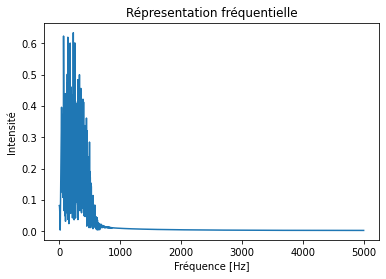

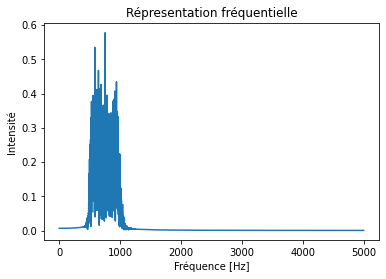

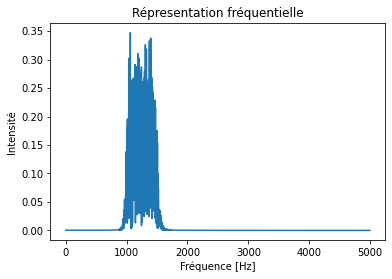

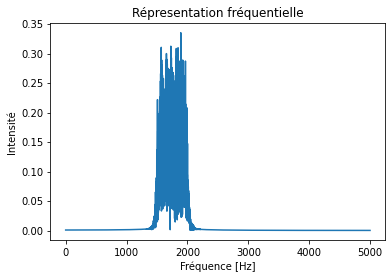

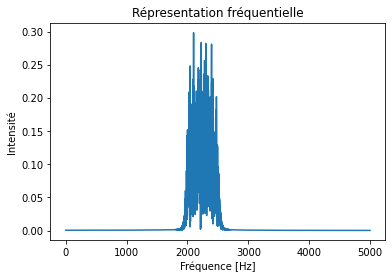

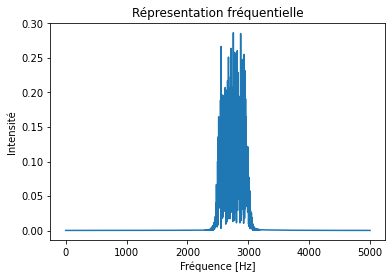

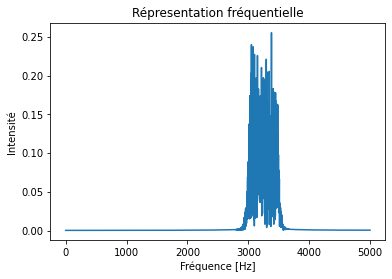

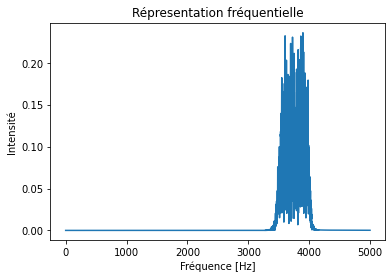

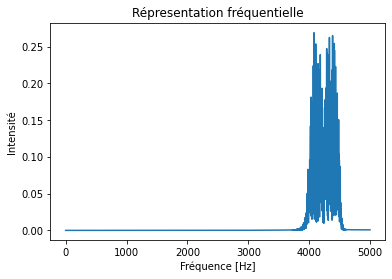

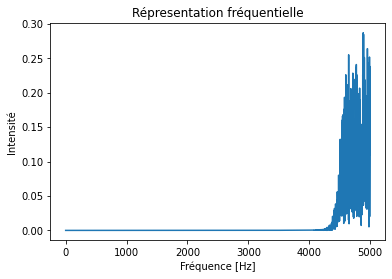

In [ ]:
bandes_temporel = []
bandes_freq = []
#Passe bas
b,a = signal.butter(6,0.1,"lowpass")
bandes_temporel.append(signal.filtfilt(b,a,Signal))
tf_sig,f_vector = computeTF(Temps,bandes_temporel[0])
f_vector = f_vector[:n//2]
bandes_freq.append(2*abs(tf_sig[:n//2])/n)

#Passes bandes
for i in range(8):
  b,a = signal.butter(6,((i+1)*0.1,(i+2)*0.1),"bandpass")
  bandes_temporel.append(signal.filtfilt(b,a,Signal))
  tf_sig,f_vector = computeTF(Temps,bandes_temporel[i+1])
  f_vector = f_vector[:n//2]
  bandes_freq.append(2*abs(tf_sig[:n//2])/n)

#Passe haut
b,a = signal.butter(6,0.9,"highpass")
bandes_temporel.append(signal.filtfilt(b,a,Signal))
tf_sig,f_vector = computeTF(Temps,bandes_temporel[9])
f_vector = f_vector[:n//2]
bandes_freq.append(2*abs(tf_sig[:n//2])/n)

for j in range(10):
  RepresFreq(f_vector,bandes_freq[j])


On a maintenant accès à 10 bandes de fréquences et on va pouvoir tester la méthode ACE et la méthode SPEAK.


In [ ]:
#Méthode ACE (maxima)
maximas = np.zeros(10)
for i in range(10):
  maximas[i] = np.max(bandes_freq[i])

bandes_a_garder = np.zeros(3)
index_sorted = np.argsort(maximas)
bandes_a_garder = index_sorted[-3:]




[0.63379977 0.57746832 0.34708066 0.33528345 0.29867006 0.28648059
 0.25531722 0.23642193 0.26899973 0.28697948]
[2 1 0]


bandes_a_garder contient les index des 3 bandes avec les maximas en ordre croissant. On va donc pouvoir créer notre signal de sortie.

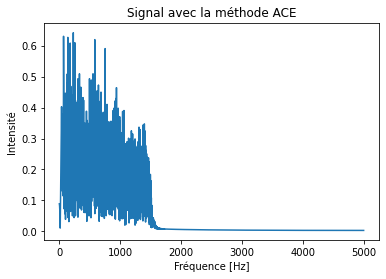

In [ ]:
signal_sortie_ACE = bandes_freq[bandes_a_garder[0]] + bandes_freq[bandes_a_garder[1]] + bandes_freq[bandes_a_garder[2]]
plt.plot(f_vector,signal_sortie_ACE)
plt.title("Signal avec la méthode ACE")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Intensité")
plt.show()

On va maintenant faire la méthode Speak.

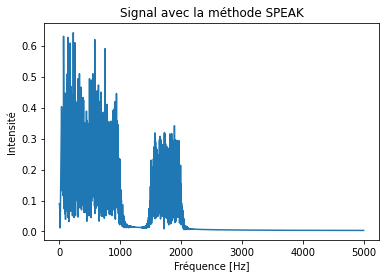

In [ ]:
#Trapèze : (h/2 * (U_(-h/2) + U_(h/2)
def Trapz(U):
  n = len(U)
  I = 0.0
  for i in range(n-1):
    I += (U[i+1]+U[i])/2
  return I

integrals = np.zeros(10)
for i in range(10):
  integrals[i] = Trapz(bandes_freq[i])

bandes_SPEAK = np.zeros(3)
index_SPEAK = np.argsort(integrals)
bandes_SPEAK = index_SPEAK[-3:]

signal_sortie_SPEAK = bandes_freq[bandes_SPEAK[0]] + bandes_freq[bandes_SPEAK[1]] + bandes_freq[bandes_SPEAK[2]]
plt.plot(f_vector,signal_sortie_SPEAK)
plt.title("Signal avec la méthode SPEAK")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Intensité")
plt.show()